## Central and Western US (Shen et al., 2013)

Description of the Model:
- Location: US west of 100°W longitude
- Grid: 0.25°x0.25°
- Stations: TA
- Ambient noise: 2005 - 2010 (828 stations)
- Earthquakes: 1550 earthquakes, Ms>5.0, 2005-2010
- Receiver functions: 828 stations, 30-90 deg distance, mb>5.0, ~130
- earthquakes/station
- Tomography: (Rayleigh waves alone)
- Ambient noise: ray theory (eikonal tomography, Lin et al., 2009), 8-40 s
- Earthquakes: finite frequency (Helmholtz tomography, Lin and Ritzwoller,2011), 25-80 s
- Parameterization:
- Isotropic v: sediment layer (linear velocity increase with depth), 4 B-spline; crust, 5 B-spline mantle
- Inversion: Bayesian Monte Carlo model space sampling.
- Forward code: Herrmann
- Moho: variable
- Format of model file: WCUS_Shen_2012
- The model was originally constructed beneath each of the 828 TA stations, but then it was interpolated onto a 0.25°x0.25° grid by simple-kriging. The resulting model appears in directory WCUS_Shen_2012 separately as a set of 1-D models for each grid point.

Reference
- Shen, W., M.H. Ritzwoller, and V. Schulte-Pelkum, A 3-D model of the crust and uppermost mantle beneath the central and western US by joint inversion of receiver functions and surface wave dispersion, J. Geophys. Res., submitted.

Datasets Example
- For example, there is file 236_40.mod.1, for (lat, lon) = (40, 236). The first few kms look
as follows:
    ```
    236 40 24.2691 1.06721687317
    0.0 1.16519 0.363969
    0.121821 1.16519 0.363969
    0.121821 2.56136 0.428722
    0.365463 2.56136 0.428722
    0.365463 2.58903 0.23161
    0.609105 2.58903 0.23161
    0.609105 2.67966 0.178154
    .
    .
    .
    ```
    The first line is formatted: lon lat Crustal_thickness (km) Error_crustal_thickness
    (km). At this point, crustal thickness is about 24.3 km and the error is estimated to be
    about 1.1 km. Then each line thereafter is: depth (km), v (km/s), Error_v (km/s). At
    layer boundaries (base of the sediments, base of the crust) there is a repeated knot so the
    model can take a discrete jump. At this point that occurs at depths of 1.096 km and 24.26
    km. The model extends to a depth of 200 km.
    The model was created by a Monte Carlo method so at each depth there is an averaging
    that produced the values in the file.

Pages: http://ciei.colorado.edu/Models/


## Step0: Downloading & Loading the Source Datasets

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

data_path = "../../../OpenSWI/Datasets/Original/OpenSWI-deep/Shen2013_USA/WUSA"
files = os.listdir(data_path)
len(files),files[0]

(6803, '236.25_40.mod.1')

## Step 1: Velocity Profile Extracting
1. Extracting
2. De-duplicating

In [2]:
# read the data
loc,vs_temp,crustal_thick = [],[],[]
max_len = 0
for file in files:
    lines = open(os.path.join(data_path, file))
    temp_data = []
    for i,line in enumerate(lines):
        line = line.strip().split()
        line = list(map(float,line))
        if i == 0:
            loc.append([line[0],line[1]])
            crustal_thick.append(line[2])
        else:
            temp_data.append([line[0],line[1]])
    vs_temp.append(temp_data)
    max_len = np.max([max_len,len(temp_data)])
vs = np.ones(((len(vs_temp),max_len,2)))*-1
for i,data in enumerate(vs_temp):
    vs[i,:len(data),:] = data
loc = np.array(loc)
vs = np.array(vs)
crustal_thick = np.array(crustal_thick)

lon,lat = loc[:,0],loc[:,1]

loc.shape,vs.shape,crustal_thick.shape

((6803, 2), (6803, 72, 2), (6803,))

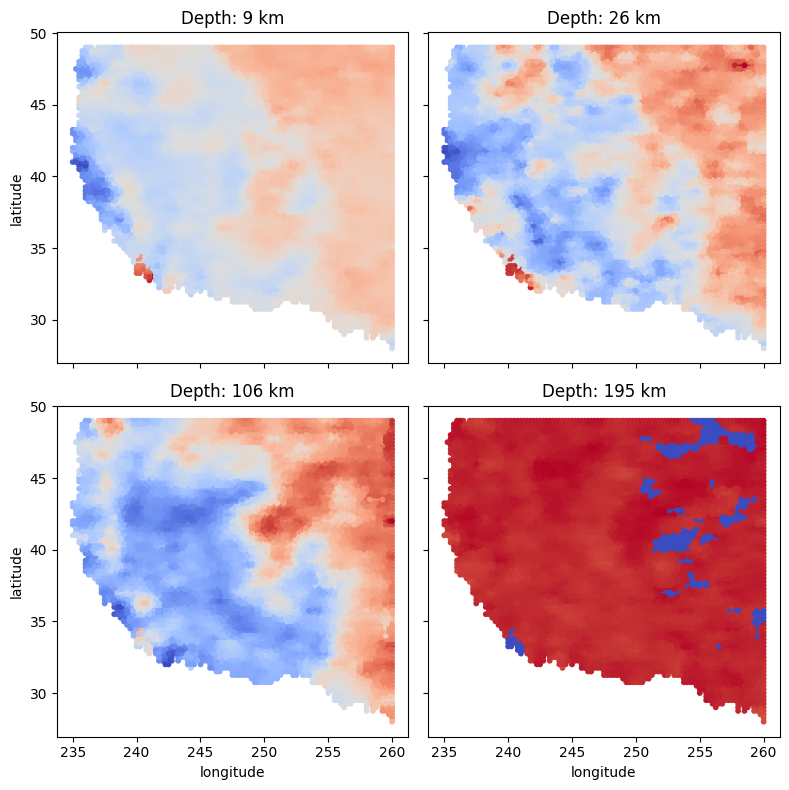

In [3]:
# plot the 
nrows,ncols = 2,2
fig,axs = plt.subplots(nrows,ncols,figsize=(8,8))
depth_idxs = [10,30,50,70]

for i in range(nrows):
    for j in range(ncols):
        depth_idx = depth_idxs[i*ncols+j]
        axs[i,j].scatter(lon,lat,c=vs[:,depth_idx,1],cmap='coolwarm', s=10)
        axs[i,j].set_title('')
        if i == nrows-1:
            axs[i,j].set_xlabel('longitude')
        else:
            axs[i,j].tick_params(labelbottom=False)
        if j == 0:
            axs[i,j].set_ylabel('latitude')
        else:
            axs[i,j].tick_params(labelleft=False)
        axs[i,j].set_title(f'Depth: {int(vs[0,depth_idx,0])} km')
plt.tight_layout()
plt.show()

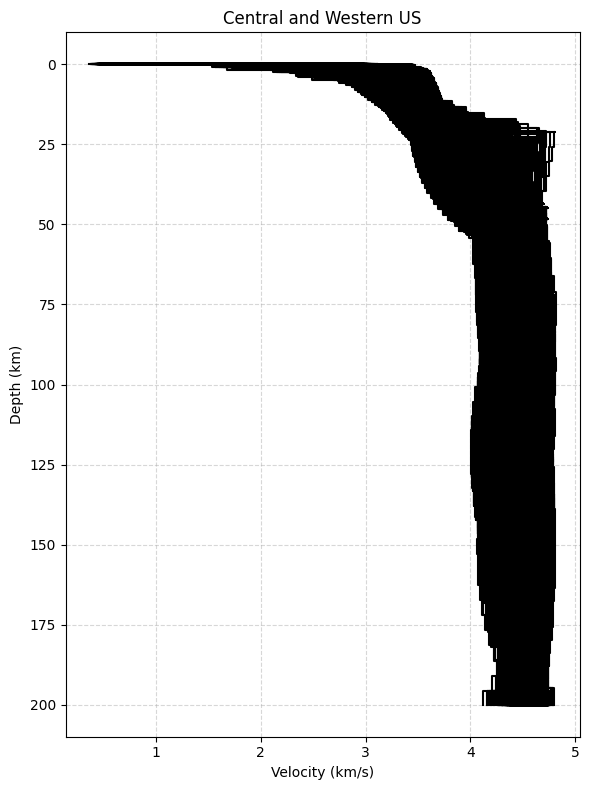

In [4]:
# single station comparsion
plt.figure(figsize=(6,8))
for i in range(vs.shape[0]):
    mask = vs[i,:,1] > 0
    plt.step(vs[i,mask,1],vs[i,mask,0],where='post',c='k')
plt.gca().invert_yaxis()
plt.grid(linestyle='--',alpha=0.5)
plt.xlabel('Velocity (km/s)')
plt.ylabel('Depth (km)')
plt.title('Central and Western US')
plt.tight_layout()
plt.show()

## Step 2: Quality Control & Interpolation

1. interpolation

2. rationalizing (remove the thin layers)


In [ ]:
import sys
sys.path.append('../../../')
from SWIDP.process_1d_deep import *
from SWIDP.dispersion import *

In [6]:
depth = vs[:,:,0]
vs = vs[:,:,1]

In [7]:
# -------------------------------------------------------
#  interpolation
# -------------------------------------------------------
from scipy.interpolate import interp1d
max_depth = 300+0.1
depth_interp = np.concatenate([
    np.arange(0, max_depth, 1)
])
vs_models = vs_interp = np.zeros((vs.shape[0],depth_interp.shape[0]))
for i in range(vs.shape[0]):
    vs_temp = vs[i,:]
    depth_temp = depth[i,:]
    depth_interp_temp = depth_interp[:np.argmin(np.abs(depth_interp-depth_temp.max()))]
    f = interp1d(depth_temp.reshape(-1),vs_temp,kind='nearest')
    vs_temp = f(depth_interp_temp)
    vs_interp[i,:len(vs_temp)] = vs_temp
vs_interp[:,len(vs_temp):] = vs_interp[:,len(vs_temp)-1].reshape(-1,1)
vs_interp.shape

(6803, 301)

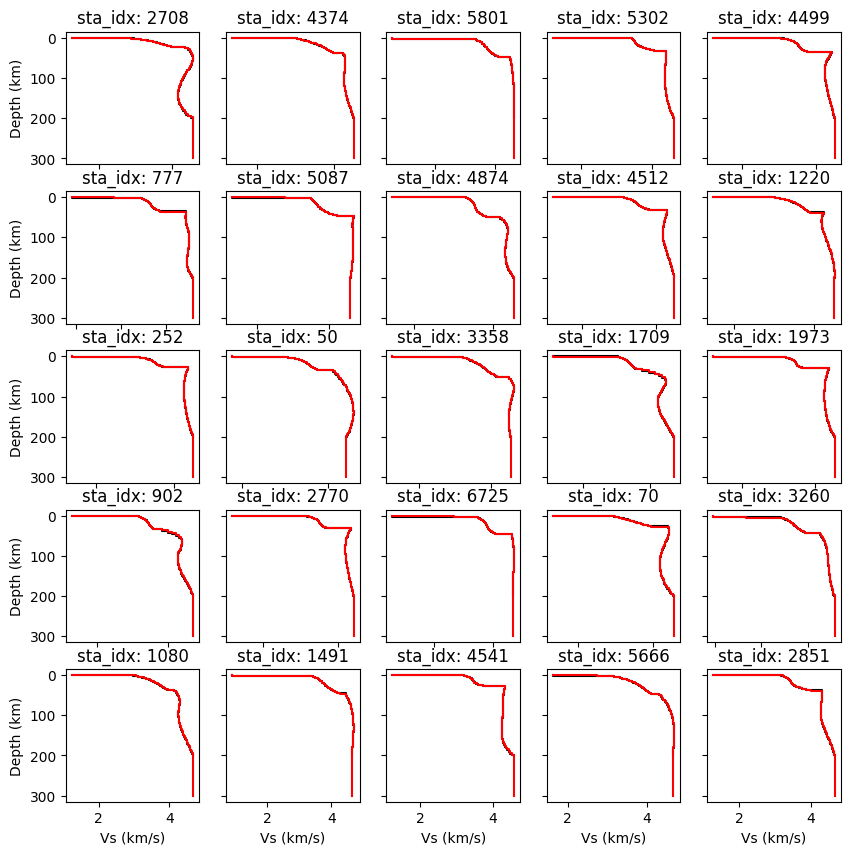

In [9]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs))
        mask = vs[sta_idx]>0
        axs[i,j].step(vs[sta_idx,mask],depth[sta_idx,mask],c='k')
        axs[i,j].step(vs_interp[sta_idx,:],depth_interp,c='r')
        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

In [10]:
# -------------------------------------------------------
#  remove the sandwich layers
# -------------------------------------------------------
from p_tqdm import p_map
# process all the stations
vs_interp_rm_sandwich = p_map(combine_thin_sandwich,
                            vs_interp,
                            list(depth_interp.reshape(1,-1))*len(vs_interp),
                            [12]*len(vs_interp),
                            [1]*len(vs_interp),
                            [0.05]*len(vs_interp),
                            [False]*len(vs_interp))

# find the moho depth
vs_interp_rm_sandwich = np.array(vs_interp_rm_sandwich)
vs_interp_rm_sandwich.shape


  0%|          | 0/6803 [00:00<?, ?it/s]

(6803, 301)

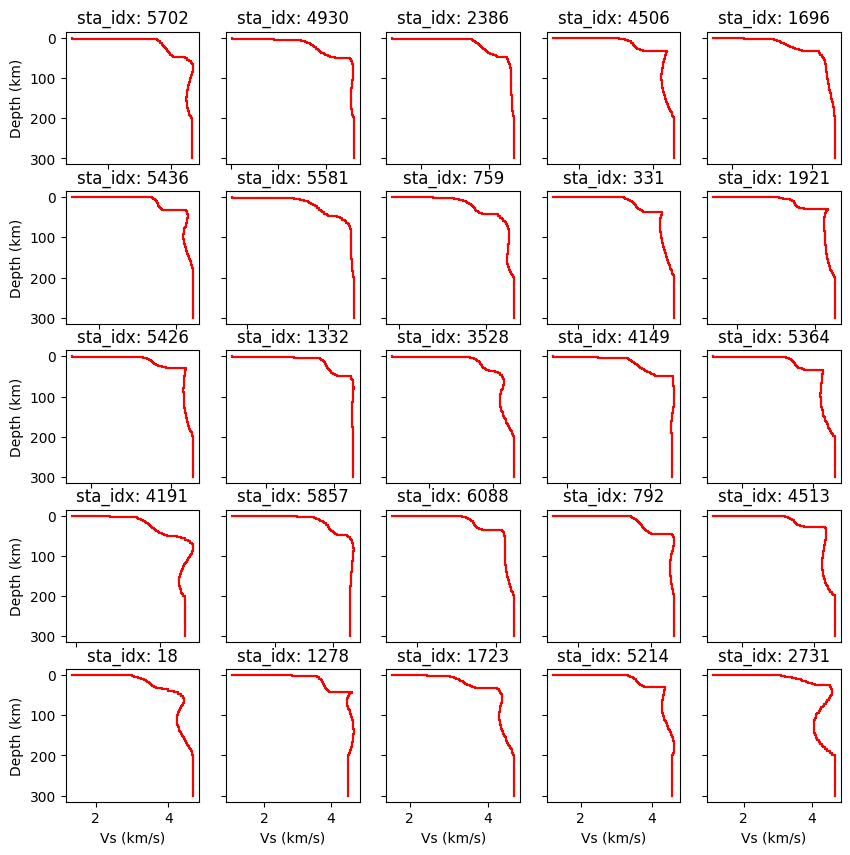

In [11]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs))
        axs[i,j].step(vs_interp[sta_idx,:],depth_interp,c='k')
        axs[i,j].step(vs_interp_rm_sandwich[sta_idx,:],depth_interp,c='r')
        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

## Step 3: Dispersion Curve Forward Modeling

In [12]:
vs_models = vs_interp_rm_sandwich.reshape(-1,vs_interp_rm_sandwich.shape[-1]) # [n_models,n_depth]
depth_models = list(depth_interp.reshape(1,-1))*len(vs_models)
vel_models = p_map(transform_vs_to_vel_model,vs_models,depth_models)
vel_models = np.array(vel_models)
vel_models.shape

  0%|          | 0/6803 [00:00<?, ?it/s]

(6803, 301, 4)

In [13]:
# Calculate dispersion curves
t = generate_mixed_samples(num_samples=300,start=1,end=100,uniform_num=100,log_num=100,random_num=100)
t = np.ones((len(vel_models),len(t)))*t
disp_data = p_map(calculate_dispersion, vel_models, list(t))
disp_data = np.array(disp_data)
vel_models = np.array(vel_models)
vel_models.shape,disp_data.shape

  0%|          | 0/6803 [00:00<?, ?it/s]

((6803, 301, 4), (6803, 300, 3))

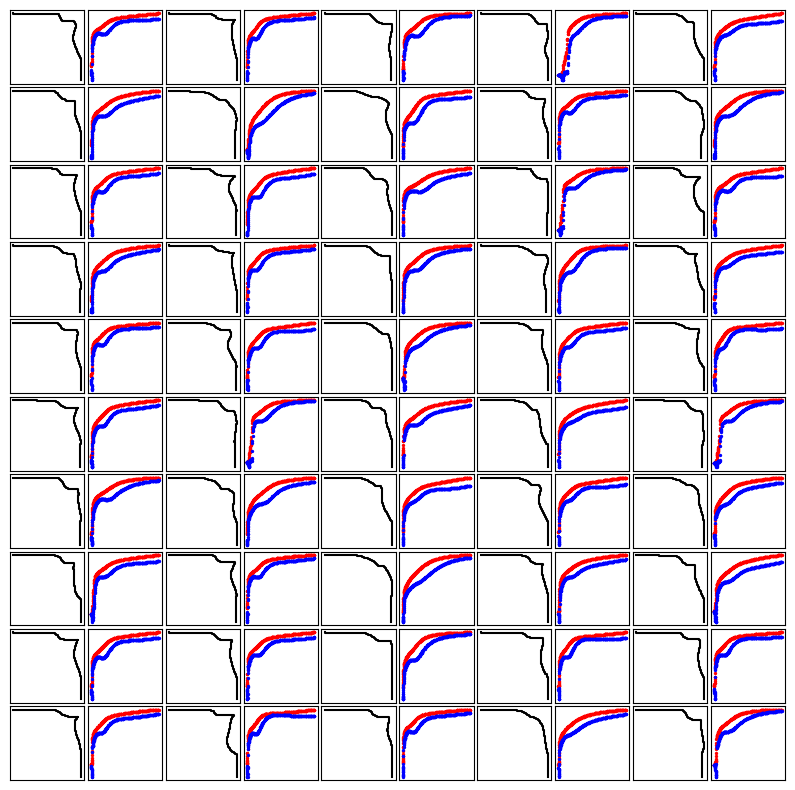

In [14]:
nrows = 10
ncols = 10
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))

for i in range(nrows):
    for j in range(ncols//2):

        sta_idx = np.random.randint(0,vel_models.shape[0])

        # velocity profile
        axs[i,j*2].step(vel_models[sta_idx][:,2],vel_models[sta_idx][:,0],c='k')
        axs[i,j*2].set_xticks([])
        axs[i,j*2].set_yticks([])
        axs[i,j*2].invert_yaxis()

        # dispersion curve
        axs[i,j*2+1].scatter(disp_data[sta_idx][:,0],disp_data[sta_idx][:,1],s=2,c='r')
        axs[i,j*2+1].scatter(disp_data[sta_idx][:,0],disp_data[sta_idx][:,2],s=2,c='b')
        axs[i,j*2+1].set_xticks([])
        axs[i,j*2+1].set_yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.show()

In [17]:
phase_mask = np.sum(disp_data[:,:,1] == 0,axis=1)==0
group_mask = np.sum(disp_data[:,:,2] == 0,axis=1)==0
mask = phase_mask*group_mask

loc = loc[mask,:]
vel_models = vel_models[mask,:,:]
disp_data = disp_data[mask,:,:]
loc.shape,vel_models.shape,disp_data.shape

((6803, 2), (6803, 301, 4), (6803, 300, 3))

In [ ]:
import os
save_base_path = "../../../OpenSWI/Datasets/OpenSWI-deep/1s-100s-Base"
# Save processed data as compressed npz files
np.savez_compressed(os.path.join(save_base_path, "Central_and_Western_US_Shen2013_loc.npz"),
                    data=loc.astype(np.float32))
np.savez_compressed(os.path.join(save_base_path, "Central_and_Western_US_Shen2013_model.npz"),
                    data=vel_models.astype(np.float32))
np.savez_compressed(os.path.join(save_base_path, "Central_and_Western_US_Shen2013_disp.npz"),
                    data=disp_data.astype(np.float32))

(array([71., 38., 32., 26., 21., 24., 23., 24., 18., 23.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

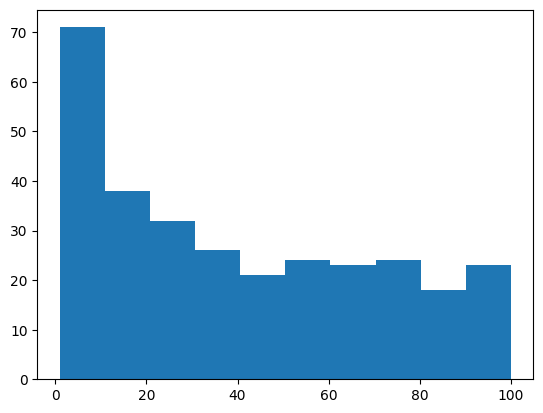

In [19]:
plt.hist(disp_data[0,:,0])